<a href="https://colab.research.google.com/github/amalvarezme/AnaliticaDatos/blob/master/ej_mainfifa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#cargar datos desde drive acceso libre
FILEID = "15QxsIm_jMfHEy6Y--6o19IWgr66oiTRe"
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id='$FILEID -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id="$FILEID -O codigos.zip && rm -rf /tmp/cookies.txt
!unzip codigos.zip
!dir

--2020-10-14 19:06:04--  https://docs.google.com/uc?export=download&confirm=&id=15QxsIm_jMfHEy6Y--6o19IWgr66oiTRe
Resolving docs.google.com (docs.google.com)... 173.194.216.102, 173.194.216.100, 173.194.216.113, ...
Connecting to docs.google.com (docs.google.com)|173.194.216.102|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0o-bg-docs.googleusercontent.com/docs/securesc/llolgb2d9qopbueo7s370dqm148t3klk/bgs1l7vac0mtnldebcur35vo7rp6vu6d/1602702300000/09173029842254050324/17702660813305837218Z/15QxsIm_jMfHEy6Y--6o19IWgr66oiTRe?e=download [following]
--2020-10-14 19:06:07--  https://doc-0o-bg-docs.googleusercontent.com/docs/securesc/llolgb2d9qopbueo7s370dqm148t3klk/bgs1l7vac0mtnldebcur35vo7rp6vu6d/1602702300000/09173029842254050324/17702660813305837218Z/15QxsIm_jMfHEy6Y--6o19IWgr66oiTRe?e=download
Resolving doc-0o-bg-docs.googleusercontent.com (doc-0o-bg-docs.googleusercontent.com)... 142.250.98.132, 2607:f8b0:400c:c1a::84
Connecting

In [2]:
#Paso 1: Lectura
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

#from funciones_fifa import dummy_fifa, pre_exploratorio, save_fig, code_euro

from sklearn.impute import SimpleImputer 
from sklearn.model_selection import train_test_split, GridSearchCV,cross_val_score, cross_val_predict
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import Pipeline


import pandas as pd
%matplotlib inline
csv_path = 'Main_Fifa/datos/data.csv'

Xdata = pd.read_csv(csv_path)

col_drop = ['Unnamed: 0', 'Name','ID','Photo','Flag',
           'Club Logo','Loaned From']
Xdata.drop(columns = col_drop, inplace = True)
Xdata.head()

,Age,Nationality,Overall,Potential,Club,Value,Wage,Special,Preferred Foot,International Reputation,Weak Foot,Skill Moves,Work Rate,Body Type,Real Face,Position,Jersey Number,Joined,Contract Valid Until,Height,Weight,LS,ST,RS,LW,LF,CF,RF,RW,LAM,CAM,RAM,LM,LCM,CM,RCM,RM,LWB,LDM,CDM,...,LB,LCB,CB,RCB,RB,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause
0,31,Argentina,94,94,FC Barcelona,€110.5M,€565K,2202,Left,5.0,4.0,4.0,Medium/ Medium,Messi,Yes,RF,10.0,7/1/2004,2021,5'7,159lbs,88+2,88+2,88+2,92+2,93+2,93+2,93+2,92+2,93+2,93+2,93+2,91+2,84+2,84+2,84+2,91+2,64+2,61+2,61+2,...,59+2,47+2,47+2,47+2,59+2,84.0,95.0,70.0,90.0,86.0,97.0,93.0,94.0,87.0,96.0,91.0,86.0,91.0,95.0,95.0,85.0,68.0,72.0,59.0,94.0,48.0,22.0,94.0,94.0,75.0,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,€226.5M
1,33,Portugal,94,94,Juventus,€77M,€405K,2228,Right,5.0,4.0,5.0,High/ Low,C. Ronaldo,Yes,ST,7.0,7/10/2018,2022,6'2,183lbs,91+3,91+3,91+3,89+3,90+3,90+3,90+3,89+3,88+3,88+3,88+3,88+3,81+3,81+3,81+3,88+3,65+3,61+3,61+3,...,61+3,53+3,53+3,53+3,61+3,84.0,94.0,89.0,81.0,87.0,88.0,81.0,76.0,77.0,94.0,89.0,91.0,87.0,96.0,70.0,95.0,95.0,88.0,79.0,93.0,63.0,29.0,95.0,82.0,85.0,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,€127.1M
2,26,Brazil,92,93,Paris Saint-Germain,€118.5M,€290K,2143,Right,5.0,5.0,5.0,High/ Medium,Neymar,Yes,LW,10.0,8/3/2017,2022,5'9,150lbs,84+3,84+3,84+3,89+3,89+3,89+3,89+3,89+3,89+3,89+3,89+3,88+3,81+3,81+3,81+3,88+3,65+3,60+3,60+3,...,60+3,47+3,47+3,47+3,60+3,79.0,87.0,62.0,84.0,84.0,96.0,88.0,87.0,78.0,95.0,94.0,90.0,96.0,94.0,84.0,80.0,61.0,81.0,49.0,82.0,56.0,36.0,89.0,87.0,81.0,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0,€228.1M
3,27,Spain,91,93,Manchester United,€72M,€260K,1471,Right,4.0,3.0,1.0,Medium/ Medium,Lean,Yes,GK,1.0,7/1/2011,2020,6'4,168lbs,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,17.0,13.0,21.0,50.0,13.0,18.0,21.0,19.0,51.0,42.0,57.0,58.0,60.0,90.0,43.0,31.0,67.0,43.0,64.0,12.0,38.0,30.0,12.0,68.0,40.0,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0,€138.6M
4,27,Belgium,91,92,Manchester City,€102M,€355K,2281,Right,4.0,5.0,4.0,High/ High,Normal,Yes,RCM,7.0,8/30/2015,2023,5'11,154lbs,82+3,82+3,82+3,87+3,87+3,87+3,87+3,87+3,88+3,88+3,88+3,88+3,87+3,87+3,87+3,88+3,77+3,77+3,77+3,...,73+3,66+3,66+3,66+3,73+3,93.0,82.0,55.0,92.0,82.0,86.0,85.0,83.0,91.0,91.0,78.0,76.0,79.0,91.0,77.0,91.0,63.0,90.0,75.0,91.0,76.0,61.0,87.0,94.0,79.0,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0,€196.4M


In [3]:
Xdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18207 entries, 0 to 18206
Data columns (total 82 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Age                       18207 non-null  int64  
 1   Nationality               18207 non-null  object 
 2   Overall                   18207 non-null  int64  
 3   Potential                 18207 non-null  int64  
 4   Club                      17966 non-null  object 
 5   Value                     18207 non-null  object 
 6   Wage                      18207 non-null  object 
 7   Special                   18207 non-null  int64  
 8   Preferred Foot            18159 non-null  object 
 9   International Reputation  18159 non-null  float64
 10  Weak Foot                 18159 non-null  float64
 11  Skill Moves               18159 non-null  float64
 12  Work Rate                 18159 non-null  object 
 13  Body Type                 18159 non-null  object 
 14  Real F

In [4]:
#Paso 2: Particion entrenamiento y validacion
# Tamaño Xtrain 70%, Tamaño Xtest 30%
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
Xtrain, Xtest = train_test_split(Xdata,test_size=0.3)
col_sal = "Release Clause"
ytrain = Xtrain[col_sal]
ytest = Xtest[col_sal]
Xtrain.drop(columns=col_sal,inplace=True)
Xtest.drop(columns=col_sal,inplace=True)


In [5]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="most_frequent")
ytrain = imputer.fit_transform(pd.DataFrame(ytrain))
ytrain = ytrain.reshape(-1)

ytest = imputer.transform(pd.DataFrame(ytest))
ytest = ytest.reshape(-1)

print(ytrain.shape, ytest.shape)

(12744,) (5463,)


In [6]:
a = ytrain[0]
print(a,print(a[1:-1]))


1.1
€1.1M None


In [7]:
#%%   
#codificar estadísticas -> jugadores fifa ej 88+3
def code_stats(y):
    yc = np.zeros(y.shape[0])
    for i in range(y.shape[0]):
        #print(y.iloc[i])
        
        if y.iloc[i].find("+") > -1: # encontrar signo mas en str y casteo a flotante
            yc[i] = float(y.iloc[i][:y.iloc[i].find("+")])+float(y.iloc[i][y.iloc[i].find("+")+1:])
        else: yc[i] = float(y.iloc[i])
        #print(yc[i])
    return yc   

#codificar moneda ->
def code_euro(y):
    yc = np.zeros(y.shape[0])
    for i in range(y.shape[0]):
      #  print(i,y[i])
        if y[i][-1]=='M': yc[i] = float(y[i][1:-1])*10**6 #buscar M y reemplazar 10^6
        elif y[i][-1]=='K': yc[i] = float(y[i][1:-1])*10**3 # buscar K y reemplazar por 10^3
        else: yc[i] = float(y[i][1:])
        #print(yc[i])
    return yc 

In [8]:
#codificar salida
ytrain_num = code_euro(ytrain)
ytest_num = code_euro(ytest)

In [9]:
ytrain_num[:5]

array([1100000.,  325000., 1100000., 1100000.,  540000.])

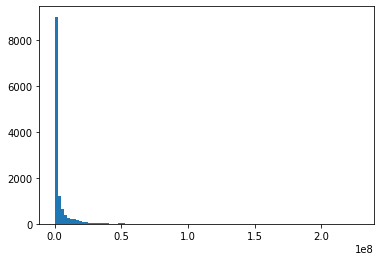

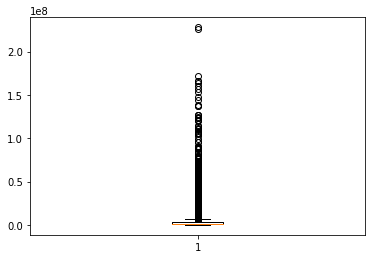

In [10]:
import matplotlib.pyplot as plt
plt.hist(ytrain_num,bins = 100)
plt.show()

plt.boxplot(ytrain_num)
plt.show()

In [11]:
#definir columnas tipo string  para codificar moneda, estadistica fifa y categoricas
col_euro = ['Value','Wage'];
col_stats = ['LS','ST','RS','LW','LF','CF','RF','RW','LAM',
             'CAM','RAM','LM','LCM','CM','RCM','RM','LWB',
             'LDM','CDM','RDM','RWB','LB','LCB','CB','RCB','RB'];

cat = ['Nationality','Club','Body Type','Position','Preferred Foot',
        'Work Rate','Real Face','Contract Valid Until']
items = [] 
for i in cat:
    items += [list(Xdata[i].value_counts().index)]# ['Alto','Medio','Bajo']
cat_usr = dict(zip(cat, items))

# Crear clase propia de preproceso para Fifa

In [12]:
#%% dummy transformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer 
from sklearn.preprocessing import OrdinalEncoder,OneHotEncoder

class dummy_fifa(BaseEstimator,TransformerMixin):
    #inicializacion de clase y varaibles
    def __init__(self, col_euro,col_stats, cat_usr): #constructor clase
        self.col_euro = col_euro #lista atributos tipo moneda
        self.col_stats = col_stats #lista atributos tipo estadistica
        self.cat_usr = cat_usr #lista de atributos categoricos

    def fit(self,X, *_):
        Xi = X.copy() #copiar dataset para no reemplazar original
        self.imputer_num = SimpleImputer(strategy="most_frequent") #crear imputador tipo modo
        self.a = Xi.columns[np.sum(Xi.isna())> 0] #encontrar columnas con datos faltantes
        #print(a)
        self.imputer_num.fit(Xi[self.a]) # ajustar imputador
        
        Xi[self.a] = self.imputer_num.transform(Xi[self.a]) #evaluar  sobre datos imputador
        #print('Cod Euros\n')
        for i in self.col_euro: #codificar tipo moneda
         #   print(i)
            Xi[i] = code_euro(np.array(Xi[i]))
        #print('Cod stats\n')    
        for i in self.col_stats: #codificar datos estadisticos
         #   print(i)
            Xi[i] = code_stats(Xi[i])
        
        #height, wieght corregir formato
        Xi['Height'].replace(regex=["'"], value='.',inplace=True)        
        for i in Xi.index:
            #print(float(Xi.loc[i,'Weight'][:-3]))
            Xi.loc[i,'Weight'] = float(Xi.loc[i,'Weight'][:-3])
            Xi.loc[i,'Height'] = float(Xi.loc[i,'Height'])
        
        Xi['Height'] = Xi['Height'].astype('float64');#print(Xi['Height'].dtype)
        
        Xi['Joined'] = Xi['Joined'].replace(regex="/",value="")
        Xi['Joined'] = Xi['Joined'].astype('float64')
        
        
        
        cat = [] #codificar variables categoricas con ordinal encoder
        for i in self.cat_usr.keys():
            cat = cat + [[*self.cat_usr.get(i)]]
        self.col_cat_usr = OrdinalEncoder(categories=cat)
        Xi[[*self.cat_usr.keys()]] =self.col_cat_usr.fit_transform(Xi[[*self.cat_usr.keys()]])
        
        #self.col_cat = Xi.columns[Xi.dtypes=='O']
        #self.cod = OrdinalEncoder()
        #self.cod.fit(Xi[self.col_cat])
        
        return self    

    def transform(self, X, *_):#funcion transformador
        Xi = X.copy()
        Xi[self.a] = self.imputer_num.transform(Xi[self.a])
        
        for i in self.col_euro:
         #   print(i)
            Xi[i] = code_euro(np.array(Xi[i]))
        #print('Cod stats\n')    
        for i in self.col_stats:
         #   print(i)
            Xi[i] = code_stats(Xi[i])
        
        #height, wieght
        Xi['Height'].replace(regex=["'"], value='.',inplace=True)        
        for i in Xi.index:
            #print(float(Xi.loc[i,'Weight'][:-3]))
            Xi.loc[i,'Weight'] = float(Xi.loc[i,'Weight'][:-3])
            Xi.loc[i,'Height'] = float(Xi.loc[i,'Height'])
        
        Xi['Height'] = Xi['Height'].astype('float64')
        Xi['Weight'] = Xi['Weight'].astype('float64')
            
        Xi['Joined'] = Xi['Joined'].replace(regex="/",value="")
        Xi['Joined'] = Xi['Joined'].astype('float64')
        
        Xi[[*self.cat_usr.keys()]] =self.col_cat_usr.transform(Xi[[*self.cat_usr.keys()]])
        #Xi[self.col_cat]= self.cod.transform(Xi[self.col_cat])
        return Xi
    
    def fit_transform(self,X,*_):
        self.fit(X)
        return self.transform(X)

In [13]:
dummy = dummy_fifa(col_euro=col_euro,col_stats=col_stats,cat_usr = cat_usr)
Xtrain_pre = dummy.fit_transform(Xtrain)

In [14]:
Xtrain_pre.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12744 entries, 12339 to 13521
Data columns (total 81 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Age                       12744 non-null  int64  
 1   Nationality               12744 non-null  float64
 2   Overall                   12744 non-null  int64  
 3   Potential                 12744 non-null  int64  
 4   Club                      12744 non-null  float64
 5   Value                     12744 non-null  float64
 6   Wage                      12744 non-null  float64
 7   Special                   12744 non-null  int64  
 8   Preferred Foot            12744 non-null  float64
 9   International Reputation  12744 non-null  float64
 10  Weak Foot                 12744 non-null  float64
 11  Skill Moves               12744 non-null  float64
 12  Work Rate                 12744 non-null  float64
 13  Body Type                 12744 non-null  float64
 14  Re

# Predicción variable de interés desde datos preprocesados

In [16]:

from sklearn.decomposition import PCA 
from sklearn.preprocessing import StandardScaler
sca = StandardScaler()
Xtrain_pre_z = sca.fit_transform(Xtrain_pre)


In [17]:
Xtrain_pre_z.var(axis=0)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [18]:
Xtrain_pre.var(axis=0)

Age                 22.076921
Nationality        422.867009
Overall             47.796104
Potential           37.762175
Club             35386.926684
                     ...     
GKDiving           313.026390
GKHandling         286.719432
GKKicking          272.895507
GKPositioning      290.133241
GKReflexes         322.829434
Length: 81, dtype: float64

In [20]:
red = PCA()
zz = red.fit_transform(Xtrain_pre_z)



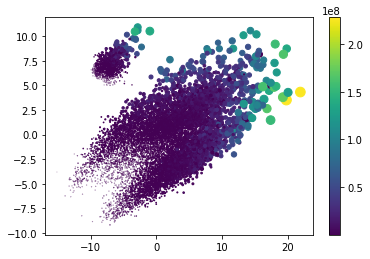

In [21]:
plt.scatter(zz[:,0],zz[:,1],c=ytrain_num,s = 100*Xtrain_pre['Value']/(Xtrain_pre['Value'].max()))
plt.colorbar()
plt.show()

In [22]:
# proceso con test
Xtest_pre = dummy.transform(Xtest)


In [23]:
Xtest_pre['Value']

4463      2600000.0
480      18000000.0
12273      375000.0
17397       70000.0
7347      1000000.0
            ...    
14014      260000.0
10628           0.0
12128      350000.0
11367      825000.0
1294       525000.0
Name: Value, Length: 5463, dtype: float64

In [24]:
Xtest_pre.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5463 entries, 4463 to 1294
Data columns (total 81 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Age                       5463 non-null   int64  
 1   Nationality               5463 non-null   float64
 2   Overall                   5463 non-null   int64  
 3   Potential                 5463 non-null   int64  
 4   Club                      5463 non-null   float64
 5   Value                     5463 non-null   float64
 6   Wage                      5463 non-null   float64
 7   Special                   5463 non-null   int64  
 8   Preferred Foot            5463 non-null   float64
 9   International Reputation  5463 non-null   float64
 10  Weak Foot                 5463 non-null   float64
 11  Skill Moves               5463 non-null   float64
 12  Work Rate                 5463 non-null   float64
 13  Body Type                 5463 non-null   float64
 14  Real 

In [25]:
#Xtest_pre_z = sca.transform(Xtest_pre) # standardizacion
#zztest = red.transform(Xtest_pre_z) # llevarlo a 2D con pca

zztest = red.transform(sca.transform(dummy.transform(Xtest))) # una sola linea

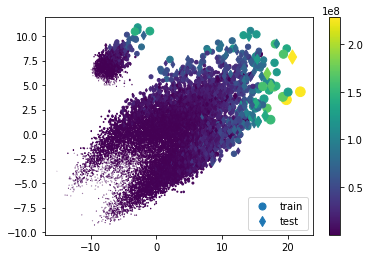

In [26]:
plt.scatter(zz[:,0],zz[:,1],c=ytrain_num,s = 100*Xtrain_pre['Value']/(Xtrain_pre['Value'].max()),label='train')
plt.colorbar()
plt.scatter(zztest[:,0],zztest[:,1],c=ytest_num,s=100*Xtest_pre['Value']/Xtest_pre['Value'].max(),marker='d',label='test')
plt.legend()
plt.show()

In [27]:
# definir modelos de predicción
from sklearn.linear_model import LinearRegression, ElasticNet

steps = [
         [('scaler', StandardScaler()), #estandarizar cada atributo columna de xtrain centrada en 0 y var = 1
          ('reg', LinearRegression())],
         
         [('scaler',StandardScaler()),
          ('reg',ElasticNet())]
         
        # [('scaler', StandardScaler()), #estandarizar cada atriuto columna de xtrain centrada en 0 y var = 1
        #  ('reg',  KernelRidge(kernel = 'rbf'))], #clasificador 
         ]        

#parametros a buscar por busqueda por grilla
parameters =[ 
             {'reg__fit_intercept':[True, False]             
             },
             {
              'reg__alpha': [0,1e-3,1e-2,1e-1,1,10], #parametros n_neighbors debe ser siempre un int
              'reg__l1_ratio':[0,0.25,0.5,0.75,1]
             }
              ]

label_model = ['Nor+RegLin','Nor+ElasticNet']

In [28]:
parameters

[{'reg__fit_intercept': [True, False]},
 {'reg__alpha': [0, 0.001, 0.01, 0.1, 1, 10],
  'reg__l1_ratio': [0, 0.25, 0.5, 0.75, 1]}]

In [29]:
import os
pathpre = 'datospre'

try:
  os.mkdir(pathpre)
except:
  print("Carpeta results ya existe")



In [30]:
#valildacion cruzada anidada
from joblib import dump, load
from sklearn.metrics import mean_absolute_error as msa 
Niter = 10 #numero particiones outter loop nested cross-validation
msev =np.zeros((Niter,len(steps)))#arreglo para guardar acierto/error
Nmod = len(steps) #numero de modelos a probar
best_estimators = Niter*[None]#mejor metodo por iteracion
###clave del funcionamiento
best_hyperpar = Niter*[None]#mejor metodo por iteracion 


#############################
for j in range(Niter): #outter loop # SI TIENE MENOS DE 1000 DATOS BORRAR ESTE CICLO SOLO CV EN LINEA 16
      #print('it %d/%d'%(j+1,Niter))
      #particiono datos outter loop
      X_trainj, X_testj, y_trainj, y_testj = train_test_split(Xtrain_pre,ytrain_num,test_size=0.3) # xtrain 60, xtest 26
      list_est = [] #lista lazo interno para guardar mejor estimador por modelo para iteracion j
      list_hyper = [] #lista lazo interno para guardar mejores hyperparametros por modelo para iteracion j
      for r in range(Nmod): #recorro todos los posibles modelos a probar en iteracion j del outter loop
          grid_search = GridSearchCV(Pipeline(steps[r],memory=pathpre), parameters[r],cv=5,verbose=5,scoring='neg_mean_absolute_error',n_jobs=-1) #cv inner loop
          #xtrain gridsearchcv xtrain split en 12 / cv, 60/5 = 12, xtrain 48 datos validar 12
          # cv = N -> leave one out N <30
          #generar mejor modelo
          grid_search.fit(X_trainj,y_trainj)
          #estimar salida conjunto de test
          y_pred = grid_search.best_estimator_.predict(X_testj)
          #guardar mejor modelo
          list_est.append(grid_search.best_estimator_)
          list_hyper.append(grid_search.best_params_)
          #guardar acierto
          msev[j,r] = msa(y_testj,y_pred)
          print('it %d/%d-Modelo %d/%d'%(j+1,Niter,r+1,len(steps)))
          print('best hyper', grid_search.best_params_)
          print('msa:',msev[j,r])
          
      best_estimators[j] = list_est #guardar mejores modelos 
      best_hyperpar[j] = list_hyper #mejores hyperparametros
          
          
      savedata = {
          'acc':msev,
          'best_models':best_estimators,
          'best_parameters':best_hyperpar,
            } 
      dump(savedata,'fifa.joblib')

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    2.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    2.7s finished


it 1/10-Modelo 1/2
best hyper {'reg__fit_intercept': True}
msa: 960469.5922382089
Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   45.4s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.5min finished


it 1/10-Modelo 2/2
best hyper {'reg__alpha': 0.01, 'reg__l1_ratio': 0}
msa: 923854.9214357629
Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    1.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    1.3s finished


it 2/10-Modelo 1/2
best hyper {'reg__fit_intercept': True}
msa: 1085901.1101431665
Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   42.3s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.4min finished


it 2/10-Modelo 2/2
best hyper {'reg__alpha': 0.1, 'reg__l1_ratio': 0.75}
msa: 895760.0670536929
Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    1.2s finished


it 3/10-Modelo 1/2
best hyper {'reg__fit_intercept': True}
msa: 974598.3991304601
Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   41.4s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.4min finished


it 3/10-Modelo 2/2
best hyper {'reg__alpha': 0.01, 'reg__l1_ratio': 0}
msa: 901009.7054338608
Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    1.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    1.3s finished


it 4/10-Modelo 1/2
best hyper {'reg__fit_intercept': True}
msa: 909918.9797060046
Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   42.6s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.4min finished


it 4/10-Modelo 2/2
best hyper {'reg__alpha': 0.01, 'reg__l1_ratio': 0}
msa: 877305.0076989783
Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    1.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    1.3s finished


it 5/10-Modelo 1/2
best hyper {'reg__fit_intercept': True}
msa: 965679.1794324142
Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   43.3s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.4min finished


it 5/10-Modelo 2/2
best hyper {'reg__alpha': 0.01, 'reg__l1_ratio': 0}
msa: 896472.414901394
Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    1.4s finished


it 6/10-Modelo 1/2
best hyper {'reg__fit_intercept': True}
msa: 944338.290636496
Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   41.4s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.4min finished


it 6/10-Modelo 2/2
best hyper {'reg__alpha': 0.01, 'reg__l1_ratio': 0}
msa: 901488.1015030929
Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    1.4s finished


it 7/10-Modelo 1/2
best hyper {'reg__fit_intercept': True}
msa: 972234.0738811983
Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   46.4s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.5min finished


it 7/10-Modelo 2/2
best hyper {'reg__alpha': 0.1, 'reg__l1_ratio': 0.75}
msa: 918759.6178064663
Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    1.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    1.3s finished


it 8/10-Modelo 1/2
best hyper {'reg__fit_intercept': True}
msa: 956070.7022609588
Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   41.0s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.3min finished


it 8/10-Modelo 2/2
best hyper {'reg__alpha': 0.1, 'reg__l1_ratio': 0.75}
msa: 899002.5640817373
Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    1.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    1.3s finished


it 9/10-Modelo 1/2
best hyper {'reg__fit_intercept': True}
msa: 954290.1908258772
Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   43.1s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.4min finished


it 9/10-Modelo 2/2
best hyper {'reg__alpha': 0.1, 'reg__l1_ratio': 0.75}
msa: 911061.434065934
Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    1.4s finished


it 10/10-Modelo 1/2
best hyper {'reg__fit_intercept': True}
msa: 1083773.5840698734
Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   43.8s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.4min finished


it 10/10-Modelo 2/2
best hyper {'reg__alpha': 0.1, 'reg__l1_ratio': 0.75}
msa: 908980.3369123504


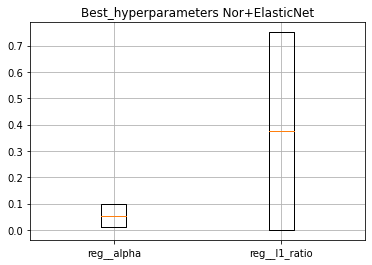

Modes=  [0.01 0.  ]


In [37]:
from scipy.stats import mode
from datetime import date

r = 1 #hyperparameters model 1
nh = len(best_hyperpar[0][r])
hyperpar_r = np.zeros((Niter,nh)) 
for i in range(Niter):
  for j in range(nh):
    hyperpar_r[i,j] = best_hyperpar[i][r].get(list(best_hyperpar[i][r].keys())[j])
    
    
#revisar numero entero para realizar casting
aa = list(best_hyperpar[0][r].keys())
c = -1
for i in range(len(aa)):
    if aa[i].find('n_neighbors') > -1:
      c = i

plt.boxplot(hyperpar_r)
plt.xticks(ticks=np.arange(nh)+1,labels=list(best_hyperpar[0][r].keys()))
plt.title('Best_hyperparameters '+label_model[r])
plt.grid()
plt.show()

mode_hyper = mode(hyperpar_r,axis=0)[0][0]
print("Modes= ", mode_hyper)

# Modelo definitivo

Con los mejores hiperparámetros entreno sobre Xtrain completo el modelo final

In [39]:
r = 1 #camino elastic net
steps_final = [('scaler',StandardScaler()),
               ('reg',ElasticNet(alpha=0.01,l1_ratio=0))]  
         
modelo_final = Pipeline(steps_final)
modelo_final.fit(Xtrain_pre,ytrain_num)

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('reg',
                 ElasticNet(alpha=0.01, copy_X=True, fit_intercept=True,
                            l1_ratio=0, max_iter=1000, normalize=False,
                            positive=False, precompute=False, random_state=None,
                            selection='cyclic', tol=0.0001,
                            warm_start=False))],
         verbose=False)

# Caso real evaluación datos nuevos

In [40]:
ytest_e = modelo_final.predict(dummy.transform(Xtest)) #simular casos nuevos

In [42]:
print('MAE_test=', msa(ytest_num,ytest_e))

MAE_test= 852025.2312084585


In [43]:
pathpre = 'resultados'

try:
  os.mkdir(pathpre)
except:
  print("Carpeta results ya existe")

In [47]:
import shutil
from joblib import dump, load
from datetime import date, datetime
from google.colab import files

modelo_final = {'modelo':modelo_final,
          'pasos':label_model[1],
          'mae_test':msa(ytest_num,ytest_e),
            } 

dump(modelo_final,'resultados/modelo_final.joblib')
namefile = str(datetime.now().strftime("%Y_%m_%d_%H_%M_%d"))+'__modelo'
shutil.make_archive(namefile, 'zip', 'resultados')
files.download(namefile+'.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Para evitar desconexión

Presionar Presionar la secuencia Crtl+Shift+i y copiar:

function ClickConnect(){
console.log("Working"); 
document.querySelector("colab-toolbar-button").click() 
}setInterval(ClickConnect,60000)